This notebook runs the Sobol analysis which is part of the open exploration.
It starts with importing all necessary packages and functions of the model. 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, ema_logging,Policy, MultiprocessingEvaluator)

from ema_workbench import Samplers

from dike_model_function import DikeNetwork  # @UnresolvedImport

from problem_formulation import get_model_for_problem_formulation

from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol
import pickle

The following code enables logging the experiments to be run.

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO);

Since we are in the open exploration, an aggregated view of the problem is sufficient for this analysis. Therefore, the second problem formulation is used. The second argument in the code below set to True makes sure that the problem formulation will not use any levers, but will use the levers as uncertainties, so that the expected interaction between levers and uncertainties can be assessed.

In [3]:
dike_model, planning_steps = get_model_for_problem_formulation(2,True)

For an overview, the lines of code below return a printed version of our problem: the amount of variables, and their names and value-range. Furthermore, also the uncertainties, outcomes and levers can be checked, so that one can make sure the levers and uncertainties are collapsed into one category.

In [4]:
uncertainties = dike_model.uncertainties 
outcomes = dike_model.outcomes
problem = get_SALib_problem(uncertainties)
#print(problem) #remove hashes for printed statement

In [5]:
#for unc in dike_model.uncertainties:
#    print(repr(unc))

In [6]:
#for out in dike_model.outcomes:
#    print(repr(out))

In [7]:
#for lev in dike_model.levers:
#    print(repr(lev.name))

The code below is only of interest when no interactions were to be expected. The lines won't be used in running the model for the report version of our outcomes.

In [8]:
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In [9]:
pol = create_policy({'0_RfR 0': 0,
     '1_RfR 0': 0,
     '2_RfR 0': 0,
     '3_RfR 0': 0,
     '4_RfR 0': 0,
     'EWS_DaysToThreat': 0,
     'A.1_DikeIncrease 0': 0,
     'A.2_DikeIncrease 0': 0,
     'A.3_DikeIncrease 0': 0,
     'A.4_DikeIncrease 0': 0,
     'A.5_DikeIncrease 0': 0,},'Upstream dike, downstream rfr')

In [10]:
#pol #unhash to view policy in case of no expected 
     #interactions between uncertainties and levers

The following code either loads results already run, runs the sobol with interactions, or without them. Since they are expected in this case, the model is run with collapsed levers and uncertainties into one category.

In [11]:
policies = pol
sobol_switch = True # decide to incorporate collapsed levers and uncertainties or the pre-defined zero-policy
n_exp = 1000
   
use_pickle1 = True
if use_pickle1: #stores result in pickles. Makes it easy to share run results in groups
    with open('data/SOBOL_results1.pickle','rb') as filehandler:
        results = pickle.load(filehandler)
elif sobol_switch == True : # runs model with levers and uncertainties collapsed into one category
    with MultiprocessingEvaluator(dike_model,n_processes=10) as evaluator:
        results = evaluator.perform_experiments(scenarios=n_exp, uncertainty_sampling=Samplers.SOBOL)
    
    with open('data/SOBOL_results1.pickle',"wb") as filehandler:
        pickle.dump(results,filehandler)
else: # runs model using the pre-defined zero-policy and pre-defined uncertainties
    with MultiprocessingEvaluator(dike_model,n_processes=10) as evaluator:
        results = evaluator.perform_experiments(scenarios=n_exp, policies = pol, uncertainty_sampling=Samplers.SOBOL)
    
    with open('data/SOBOL_results1.pickle',"wb") as filehandler:
        pickle.dump(results,filehandler)  
experiments_sobol, outcomes_sobol = results

Now, the sobol outcomes can be stored. Two outcomes are of interest: the expected deaths and the damages.

In [12]:
deaths_sobol = sobol.analyze(problem, outcomes_sobol['Expected Number of Deaths'],calc_second_order=True, print_to_console=False)
damages_sobol = sobol.analyze(problem, outcomes_sobol['Expected Annual Damage'],calc_second_order=True, print_to_console=False)

First, the process of analysis is executed for the deaths-variable. The whole process is repeated for the damages-variable. 

First, a dataframe is created which incorporates all first (S1) and total (ST) order variances of the uncertainties. Those uncertainties with a significant difference (0.05 difference is taken) between S1 and ST are expected to have second order interactions that make up variance as well. Those that seem to have second order interactions are shown in a dataframe.

In [13]:
Si_filter = {k:deaths_sobol[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df_deaths = pd.DataFrame(Si_filter, index=problem['names'])  # create df with uncertainties as index
Si_df_deaths['ST-S1'] = Si_df_deaths['ST'] - Si_df_deaths['S1'] # compute significant differences
Si_df_deaths['Second order interaction'] = np.where(Si_df_deaths['ST-S1'] > 0.05, True, False) # check significance
Si_df_deaths_2nd = Si_df_deaths.loc[Si_df_deaths['Second order interaction'] == True] # remove all insignificant variables
Si_df_deaths_2nd #show remaining 2nd order variables

,ST,ST_conf,S1,S1_conf,ST-S1,Second order interaction
0_RfR 1,0.070412,0.122211,0.003341,0.018623,0.067071,True
0_RfR 2,0.072011,0.081047,-0.005703,0.006908,0.077714,True
1_RfR 2,0.049142,0.056198,-0.002782,0.003878,0.051924,True
2_RfR 0,0.055226,0.051968,0.005093,0.009331,0.050132,True
A.1_DikeIncrease 0,0.170967,0.251607,-0.004946,0.008900,0.175913,True
A.1_pfail,0.092125,0.111517,0.000995,0.008326,0.091130,True
A.2_DikeIncrease 0,0.049777,0.062079,-0.009276,0.026264,0.059052,True
A.2_pfail,0.128336,0.138545,0.034571,0.079322,0.093765,True
A.3_DikeIncrease 0,0.471613,0.599725,0.006840,0.017944,0.464773,True
A.3_pfail,0.500976,0.349177,0.036619,0.031989,0.464357,True


The following code shows a dataframe indicating checking for the actual second order interactions at hand. In the report, an evaluation is given of the second order interactions that influence both explain the variables variance for at least 5%.

In [14]:
pd.set_option('display.max_columns', None) # We want to see all pairs of interaction

## First, create matrix df with variable names on axes, and fill NaNs with 0.

S2_deaths_sobol = pd.DataFrame(deaths_sobol['S2'])
S2_deaths_sobol.index = Si_df_deaths.index
S2_deaths_sobol.columns = Si_df_deaths.index
S2_deaths_sobol= S2_deaths_sobol.fillna(0)

## Then, check which combinations are influencing outcomes for more than 5%.

S2_deaths_sobol_boolean = S2_deaths_sobol>0.05
S2_deaths_sobol_boolean.any(axis='columns')
S2_deaths_sobol_boolean = S2_deaths_sobol_boolean.iloc[[18,21,30,33,46]]
S2_deaths_sobol_boolean

## Then, show how big these second-order influences are
S2_deaths_sobol= S2_deaths_sobol.iloc[[18,21,30,33,46]]
S2_deaths_sobol

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.5_pfail,EWS_DaysToThreat,discount rate 0,discount rate 1,discount rate 2
A.1_DikeIncrease 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053034,0.053034,0.093391,0.053032,0.053035,0.053160,0.053028,0.053034,0.051966,0.053035,0.053034,0.042368,0.051645,0.053034,0.009480,0.053034,0.053034,0.053265,0.053018,0.053034,0.053017,0.053034,0.053034,0.052420,0.051308,0.053034,0.046458,0.059133,0.053034,0.053034,0.053034
A.1_pfail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.063927,0.063930,0.062794,0.063907,0.063929,0.061465,0.063930,0.063930,0.020311,0.051340,0.062749,0.006652,0.063930,0.063930,0.063812,0.063920,0.063930,0.063897,0.063930,0.063930,0.064352,0.063973,0.063930,0.068099,0.173467,0.063930,0.063930,0.063930
A.3_DikeIncrease 0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002166,0.002399,0.175635,0.002152,0.002151,0.002452,0.002157,0.002149,0.002249,0.002151,0.002151,0.004377,0.003096,0.001961,0.012456,0.013698,0.002151,0.002151,0.002151
A.3_pfail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106045,0.106032,0.106107,0.106058,0.106035,0.105927,0.106032,0.106032,0.104725,0.107585,0.106533,0.105136,0.079191,0.106032,0.106032,0.106032
EWS_DaysToThreat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080601,0.080601,0.080601


Furthermore, S1 and ST are shown in figures for all sole uncertainties that influence its variance for more than 5%. 

In [15]:
Si_df_deaths = Si_df_deaths[Si_df_deaths['ST']>0.05]
Si_df_deaths

,ST,ST_conf,S1,S1_conf,ST-S1,Second order interaction
0_RfR 1,0.070412,0.122211,0.003341,0.018623,0.067071,True
0_RfR 2,0.072011,0.081047,-0.005703,0.006908,0.077714,True
2_RfR 0,0.055226,0.051968,0.005093,0.009331,0.050132,True
A.1_DikeIncrease 0,0.170967,0.251607,-0.004946,0.008900,0.175913,True
A.1_pfail,0.092125,0.111517,0.000995,0.008326,0.091130,True
A.2_pfail,0.128336,0.138545,0.034571,0.079322,0.093765,True
A.3_DikeIncrease 0,0.471613,0.599725,0.006840,0.017944,0.464773,True
A.3_pfail,0.500976,0.349177,0.036619,0.031989,0.464357,True
A.5_DikeIncrease 0,0.071980,0.088008,0.003615,0.009796,0.068365,True
EWS_DaysToThreat,0.413114,0.301348,0.000336,0.016676,0.412778,True


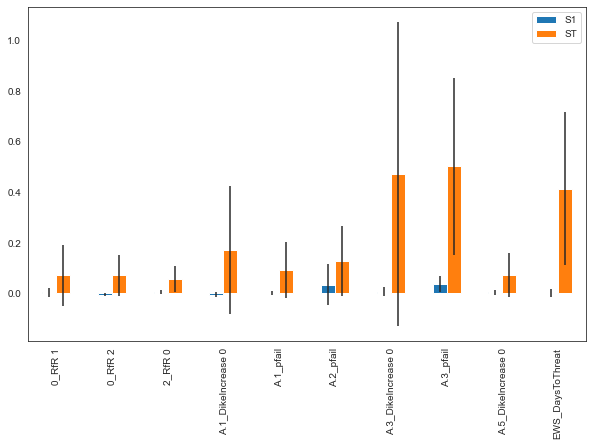

In [16]:
sns.set_style('white')
fig, ax = plt.subplots(1)

indices_de = Si_df_deaths[['S1','ST']]
err_de = Si_df_deaths[['S1_conf','ST_conf']]

indices_de.plot.bar(yerr=err_de.values.T,ax=ax)
fig.set_size_inches(10,8)
fig.subplots_adjust(bottom=0.3)
fig.savefig(fname="images/Open exploration/sobol_deaths.png", dpi=200,format="png")
plt.show()

And perform the same analysis for the damages-variable.

In [17]:
Si_filter = {k:damages_sobol[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df_damages = pd.DataFrame(Si_filter, index=problem['names'])
Si_df_damages['ST-S1'] = Si_df_damages['ST'] - Si_df_damages['S1']
Si_df_damages['Second order interaction'] = np.where(Si_df_damages['ST-S1'] > 0.05, True, False)
Si_df_damages_2nd = Si_df_damages.loc[Si_df_damages['Second order interaction'] == True]
Si_df_damages_2nd

,ST,ST_conf,S1,S1_conf,ST-S1,Second order interaction
0_RfR 1,0.131752,0.104835,-0.005393,0.019605,0.137144,True
0_RfR 2,0.114350,0.095762,-0.014788,0.020075,0.129139,True
1_RfR 0,0.087746,0.095812,0.000130,0.005667,0.087617,True
1_RfR 1,0.055438,0.065801,-0.031376,0.057362,0.086815,True
1_RfR 2,0.063095,0.069489,-0.003651,0.005325,0.066747,True
A.1_DikeIncrease 0,0.326621,0.255923,-0.006497,0.019472,0.333118,True
A.1_pfail,0.273802,0.126636,0.008198,0.030847,0.265604,True
A.3_DikeIncrease 0,0.203985,0.100789,0.022285,0.017762,0.181699,True
A.3_pfail,0.449283,0.222157,0.071941,0.056614,0.377343,True


In [18]:
S2_damages_sobol = pd.DataFrame(damages_sobol['S2'])
S2_damages_sobol.index = Si_df_damages.index
S2_damages_sobol.columns = Si_df_damages.index
S2_damages_sobol.fillna(0,inplace=True)

S2_damages_sobol_boolean = S2_damages_sobol>0.05
S2_damages_sobol_boolean
S2_damages_sobol_boolean.any(axis='columns')
S2_damages_sobol_boolean = S2_damages_sobol_boolean.iloc[[4,18,21,30,33]]

S2_damages_sobol= S2_damages_sobol.iloc[[4,18,21,30,33]]
S2_damages_sobol

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.5_pfail,EWS_DaysToThreat,discount rate 0,discount rate 1,discount rate 2
1_RfR 1,0.0,0.0,0.0,0.0,0.0,0.048047,0.047791,0.04724,0.048299,0.047926,0.048172,0.048329,0.048084,0.048083,0.048022,0.049132,0.048047,0.048047,0.048053,0.048047,0.048047,0.043637,0.047922,0.048010,0.047131,0.047893,0.048043,0.042989,0.048016,0.048061,0.049108,0.047693,0.048047,0.047352,0.048047,0.048047,0.048329,0.048028,0.048047,0.048011,0.048047,0.048047,0.042009,0.052458,0.048058,0.036132,0.048047,0.045625,0.048414,0.048047
A.1_DikeIncrease 0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052957,0.052957,0.231068,0.052947,0.052962,0.053654,0.052811,0.052953,0.048680,0.052961,0.052954,0.045665,0.051936,0.052957,0.023459,0.052957,0.052957,0.052996,0.052912,0.052957,0.052938,0.052957,0.052957,0.048704,0.049176,0.052957,0.029522,0.052957,0.048294,0.054958,0.052980
A.1_pfail,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089295,0.089313,0.088765,0.088979,0.089304,0.088246,0.089312,0.089305,0.068606,0.082698,0.088851,0.107453,0.089308,0.089308,0.088787,0.089304,0.089308,0.089013,0.089308,0.089308,0.095667,0.089310,0.089308,0.095394,0.089308,0.096997,0.086810,0.089308
A.3_DikeIncrease 0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018044,-0.017371,0.233589,-0.018072,-0.018082,-0.016550,-0.017921,-0.018086,-0.017709,-0.018082,-0.018082,-0.019947,-0.016697,-0.019100,0.007277,-0.018082,-0.023546,-0.016795,-0.018162
A.3_pfail,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054075,0.054057,0.056065,0.054454,0.054051,0.053787,0.054057,0.054057,0.045360,0.054964,0.056047,0.051056,0.054057,0.055075,0.049687,0.057312


In [19]:
Si_df_damages = Si_df_damages[Si_df_damages['ST']>0.05]
Si_df_damages

,ST,ST_conf,S1,S1_conf,ST-S1,Second order interaction
0_RfR 1,0.131752,0.104835,-0.005393,0.019605,0.137144,True
0_RfR 2,0.114350,0.095762,-0.014788,0.020075,0.129139,True
1_RfR 0,0.087746,0.095812,0.000130,0.005667,0.087617,True
1_RfR 1,0.055438,0.065801,-0.031376,0.057362,0.086815,True
1_RfR 2,0.063095,0.069489,-0.003651,0.005325,0.066747,True
A.1_DikeIncrease 0,0.326621,0.255923,-0.006497,0.019472,0.333118,True
A.1_pfail,0.273802,0.126636,0.008198,0.030847,0.265604,True
A.2_pfail,0.089647,0.049407,0.068468,0.059040,0.021179,False
A.3_DikeIncrease 0,0.203985,0.100789,0.022285,0.017762,0.181699,True
A.3_pfail,0.449283,0.222157,0.071941,0.056614,0.377343,True


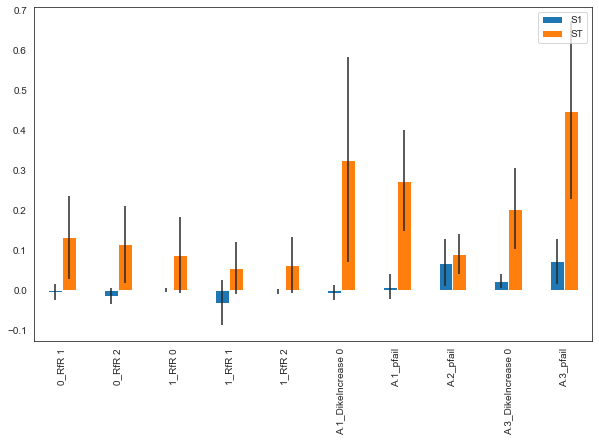

In [20]:
sns.set_style('white')
fig, ax = plt.subplots(1)
err_da = Si_df_damages[['S1_conf','ST_conf']]
indices_da = Si_df_damages[['S1','ST']]
indices_da.plot.bar(yerr=err_da.values.T,ax=ax)
fig.set_size_inches(10,8)
fig.subplots_adjust(bottom=0.3)
fig.savefig(fname="images/Open exploration/sobol_damages.png", dpi=200,format="png")
plt.show()